In [65]:
import os
import shutil
import json
import requests
from PIL import Image
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import Progbar

In [55]:
class GlobalEnvironment:
    def __init__(self, data_url, data_path, data_file_name):
        self.data_url = data_url
        self.data_path = data_path
        self.data_file_name = data_file_name
        
        self.data_file_path = os.path.join(data_path, data_file_name)
        
Global = GlobalEnvironment(data_url = 'https://db.ygoprodeck.com/api/v7/cardinfo.php',
                           data_path = 'data',
                           data_file_name = 'archetypes.csv')

In [66]:
r = requests.get(Global.data_url)
data = r.json()
pdata = json.dumps(data, indent=4)
# Print the type of data variable
print("Type:", type(data))
print(data['data'][0]['archetype'])

# Print the data of dictionary
print("\nArchetype Card:", json.dumps(data['data'][0], indent=4))
print("\nNon-Archetype Card:", json.dumps(data['data'][8], indent=4))

Type: <class 'dict'>
Alien

Archetype Card: {
    "id": 34541863,
    "name": "\"A\" Cell Breeding Device",
    "type": "Spell Card",
    "desc": "During each of your Standby Phases, put 1 A-Counter on 1 face-up monster your opponent controls.",
    "race": "Continuous",
    "archetype": "Alien",
    "card_sets": [
        {
            "set_name": "Force of the Breaker",
            "set_code": "FOTB-EN043",
            "set_rarity": "Common",
            "set_rarity_code": "(C)",
            "set_price": "1.62"
        }
    ],
    "card_images": [
        {
            "id": 34541863,
            "image_url": "https://storage.googleapis.com/ygoprodeck.com/pics/34541863.jpg",
            "image_url_small": "https://storage.googleapis.com/ygoprodeck.com/pics_small/34541863.jpg"
        }
    ],
    "card_prices": [
        {
            "cardmarket_price": "0.16",
            "tcgplayer_price": "0.26",
            "ebay_price": "4.99",
            "amazon_price": "3.94",
            "

archetype      
No_Archetype       5064
Elemental HERO      128
Performapal          79
Archfiend            78
Blackwing            73
D/D                  62
Roid                 56
Gladiator Beast      56
Noble Knight         50
Dark Magician        50
dtype: int64


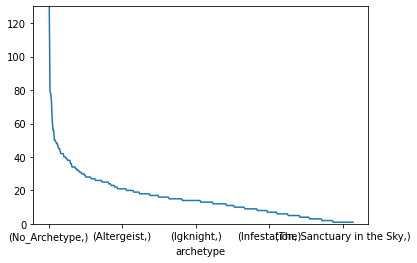

In [87]:
# r = requests.get("https://db.ygoprodeck.com/api/v7/cardinfo.php")
# data = r.json()
def create_dataset():
    cards = data['data']
    n = len(cards)
    prog = Progbar(n)
    # iterate through every card; index needed for progress bar
    for i in range(n):
        card = cards[i]
        
        # some cards do not have an archetype field; label it as 'No_Archetype' (this will cause an error otherwise)
        # also, some archetypes have slashes which is problematic. replace those with underscores
        archetype_path = os.path.join(Global.data_path, (card['archetype'] if 'archetype' in card else 'No_Archetype').replace("/", "_"))
        # make directory if archetype doesn't exist
        if not os.path.isdir(archetype_path):
            os.mkdir(archetype_path)
            
        for image in card['card_images']:
            file_path = os.path.join(archetype_path, '{}.png'.format(image['id']))
            # if we've fetched the image for this card ID previously, skip it
            if not os.path.exists(file_path):
                url = image['image_url']
                # fetch raw picture content from URL
                # https://stackoverflow.com/a/18043472
                response = requests.get(url, stream=True)
                with open(file_path, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
        
        # update progress bar so we know how long this is going to take
        prog.update(i)
    # finish progress bar
    prog.update(n, finalize=True)
    
def generate_csv():
    cards = pd.DataFrame(data['data'])
    print(cards.loc[0, ['archetype']])
    cards['archetype'] = cards['archetype'].fillna('No_Archetype')
    # cards = cards.loc[:, ['card_images'[:, 'id'], 'archetype']]
    # cards = cards['id', 'archetype']
    entries = []
    for i in range(len(cards)):
        card = cards.loc[i]
        for j in range(len(card.loc['card_images'])):
            image = card.loc['card_images'][j]
        entries.append([os.path.join(Global.data_path, card['archetype'], '{}.png'.format(image['id'])), image['id'], card['archetype']])

    entries = pd.DataFrame(entries)
    for i in range(10):
        print(entries.iloc[i])
    entries.columns = ['file_path', 'id', 'archetype']
    entries.to_csv(Global.data_file_path, index=False)

def generate_freqs():
    freqs = pd.read_csv(Global.data_file_path, delimiter=',').value_counts(subset=['archetype'])
    # freqs = pd.DataFrame(freqs)
    print(freqs[:10])
    freqs.plot(ylim=(0, 130))
        
# create_dataset()
# generate_csv()
# generate_freqs()